# Lab T3E3
## James Camacho, Ashish Kalakuntla, Eric Bui

# Aim 1
## Pre-Lab
1. $Q = 3 \text{GHz} / 100 \text{kHz} = 3\cdot 10^4.$

In [ ]:
!pip install --upgrade matplotlib

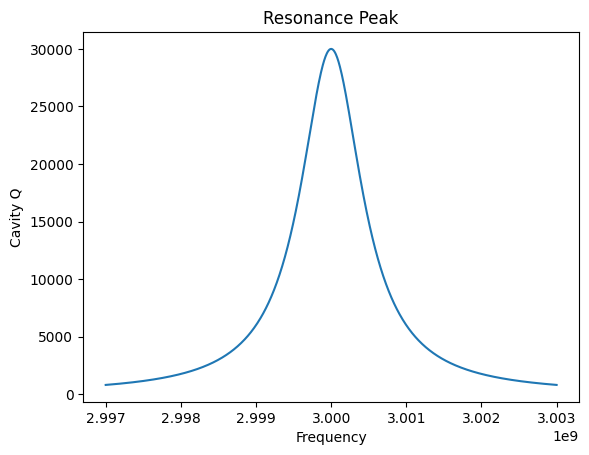

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

center = 3e9
span = 1e6
linewidth = 1e5
f = np.linspace(center-3*span, center+3*span, 1000)
def Lorentz(x, center, span):
  return span / (2 * (x - center)**2 + span**2 / 2) / np.pi

peak = Lorentz(center, center, span)
Q = Lorentz(f, center, span)
Q *= center / linewidth / peak # normlize

plt.title("Resonance Peak")
plt.xlabel("Frequency")
plt.ylabel("Cavity Q")
plt.plot(f, Q)
plt.show()

3. We have $$\mu = \mu_Bg/h \approx \frac{9.274\cdot 10^{-24}\text{J}/\text{T}}{6.626\cdot 10^{-34}\text{J}/\text{Hz}}\cdot 2 = 2.799\cdot 10^{10}\ \text{Hz}/\text{T} = 2.799\ \text{MHz}/\text{Gauss}.$$
4. We need $$\mu B = (3.00-2.87)\cdot 10^3 \text{MHz}\implies B = 46\ \text{Gauss}.$$

## Lab

Outer radius of resonator: 0.37in = 9.4mm

Axial length: 0.25in = 6.35mm

Need to solve

$$\zeta \tan\left(\frac{\zeta L}{2}\right) = \zeta_0$$
$$\zeta = \sqrt{\epsilon_r \frac{\omega_c^2}{c^2}-\frac{x_{01}^2}{r_d^2}}$$
$$\zeta_0 = \sqrt{\frac{x_{01}^2}{r_d^2}-\frac{\omega_c^2}{c^2}}$$

which is equivalent to

$$\frac{1}{\epsilon_r}\left[\zeta^2-\frac{x_{01}^2}{r_d^2}\right] = \frac{\omega_c^2}{c^2} = \frac{x_{01}^2}{r_d^2} - \zeta^2\tan^2\left(\frac{\zeta L}{2}\right).$$

/var/folders/kt/lg1nn6250kn4s0j98xb0k5jr0000gn/T/ipykernel_7295/3080645597.py:19: RuntimeWarning: invalid value encountered in sqrt
  return ((x01**2/rd**2 - zeta**2) / er) ** 0.5 * c
/var/folders/kt/lg1nn6250kn4s0j98xb0k5jr0000gn/T/ipykernel_7295/3080645597.py:22: RuntimeWarning: invalid value encountered in sqrt
  return (zeta**2*np.tan(zeta*L/2)**2 - x01**2/rd**2) ** 0.5 * c


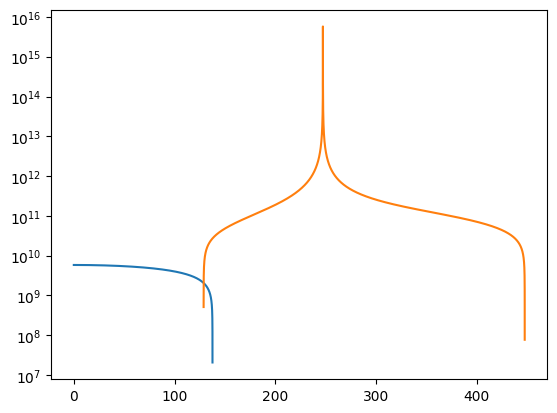

wc = 2.049e+09


In [ ]:
from mpmath import findroot, tan
x01 = 2.4048
# L = 2*6.35e-3 # James' numbers
# rd = 9.4e-3 # For some reason gives the right answer if we multiply the radius by 10... Unit error?

L = 2*0.25*2.54e-2 # Kevin's numbers
rd = 11/16*2.54e-2

er = 50.0
c = 2.9979e8

def f(zeta):
  try:
    return zeta**2*(tan(zeta*L/2)**2 + 1/er) - x01**2/rd**2 * (1 + 1/er)
  except:
    return zeta**2*(np.tan(zeta*L/2)**2 + 1/er) - x01**2/rd**2 * (1 + 1/er)

def zeta_to_wc(zeta):
  return ((x01**2/rd**2 - zeta**2) / er) ** 0.5 * c

def zeta_to_wc2(zeta):
  return (zeta**2*np.tan(zeta*L/2)**2 - x01**2/rd**2) ** 0.5 * c

zeta = np.linspace(0, 500, 100000)
plt.plot(zeta, zeta_to_wc(zeta))
plt.plot(zeta, zeta_to_wc2(zeta))
plt.yscale('symlog')
plt.show()

zeta = float(findroot(f, 1.5e2))
wc = zeta_to_wc(zeta)
print(f"wc = {wc:.3e}")

In [ ]:
# Attempt using Newton's method failed.

def f_prime(zeta, zeta_0, wc):
  s = np.sqrt(er*wc**2/c**2 - x01**2/rd**2)
  s2 = np.sqrt(x01**2/rd**2 - wc**2/c**2)
  J = [[zeta / np.cos(zeta*L/2)**2*L/2+np.tan(zeta*L/2), -1, 0],
       [1, 0, -er*wc/c**2/s],
       [0, 1, wc/c**2/s2]]
  return np.array(J)

def f(zeta, zeta_0, wc):
  vals = [zeta*np.tan(zeta*L/2) - zeta_0, zeta - np.sqrt(er*wc**2/c**2 - x01**2/rd**2), zeta_0 - np.sqrt(x01**2/rd**2 - wc**2/c**2)]
  return np.array(vals, dtype=np.complex64)

def g_prime(zeta, wc):
  sqrt1 = np.sqrt(er*wc**2/c**2 - x01**2/rd**2)
  sqrt2 = np.sqrt(x01**2/rd**2 - wc**2/c**2)
  J = [[1, -er*wc/c**2/sqrt1],
       [zeta*L/2/np.cos(zeta*L/2)**2+np.tan(zeta*L/2), wc/c**2/sqrt2]]
  return np.array(J)

def g(zeta, wc):
  return f(zeta, zeta*np.tan(zeta*L/2), wc)[1:]

def fixed_point(zeta, zeta_0, wc):
  s = np.sqrt(er*wc**2/c**2 - x01**2/rd**2)
  s2 = c*np.sqrt(x01**2/rd**2 - zeta_0**2)
  return np.array([zeta_0/np.tan(zeta*L/2), s, s2])

def Newton(k):
  z = np.array([k*5e2, 3e9+0j])
  if abs(k) == 1:
    # Get the first stripe closer
    z[0] /= 3
  elif k > 0:
    z[0] -= 5e2
  elif k < 0:
    z[0] += 5e2

  for i in range(200):
    z -= np.linalg.solve(g_prime(*z), g(*z))

  return z

zetas = []
wcs = []
for k in range(-10, 10):
  zeta, wc = Newton(k)
  if abs(zeta.imag) < 1 and abs(wc.imag) < 1:
    zeta, wc = zeta.real, wc.real
    zetas.append(zeta)
    wcs.append(wc)
    print(f"zeta = {zeta:.3e}, wc = {wc:.3e}")

zeta = -5.495e+02, wc = -2.071e+10
zeta = 1.280e+02, wc = 7.970e+09
zeta = 1.280e+02, wc = 7.970e+09
zeta = 5.282e+02, wc = 2.314e+10


0.0 0.0


/Users/qpgroup/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/qpgroup/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/qpgroup/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


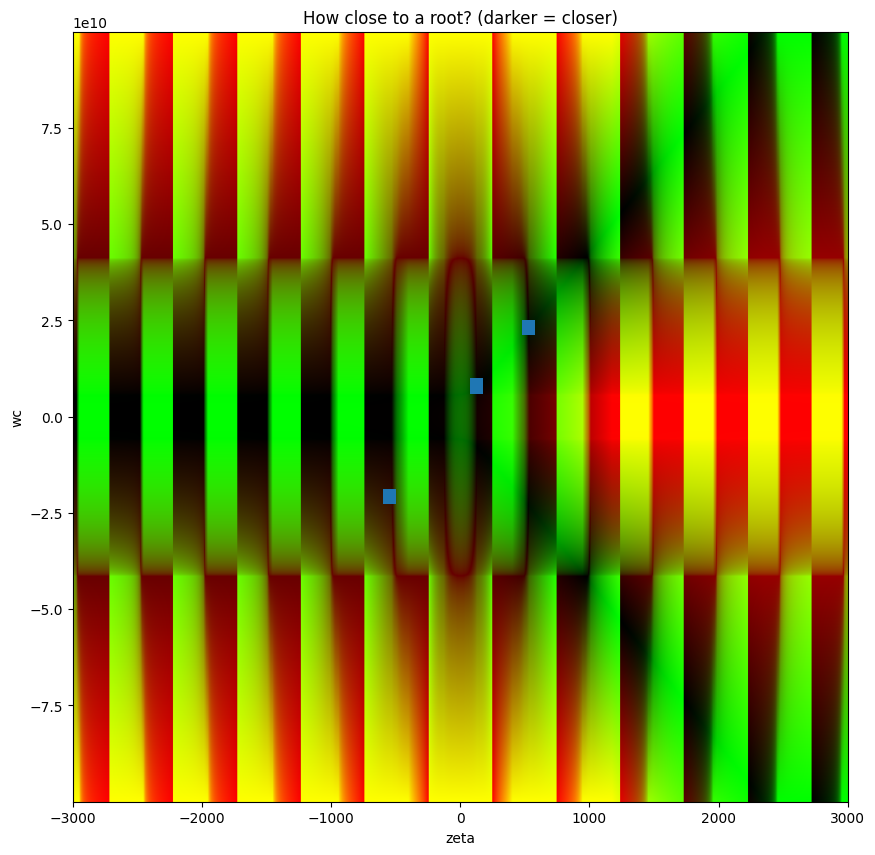

In [ ]:
# Drawing roots (from above)

wc = np.linspace(-1e11, 1e11, 1000, dtype=np.complex64)
zeta = np.linspace(-3e3, 3e3, 1000, dtype=np.complex64)
wc, zeta = np.meshgrid(wc, zeta)


# Grab and format data
g0, g1 = np.abs(g(zeta, wc))
g0 -= np.nanmin(g0, axis=-1)[:,None]
g0 /= np.nanmax(g0, axis=-1)[:,None]
g1 -= np.nanmin(g1, axis=-1)[:,None]
g1 /= np.nanmax(g1, axis=-1)[:,None]

print(np.nanmin(g0), np.nanmin(g1))

# Third color that doesn't mean anything.
g2 = np.zeros_like(g1)
plt.figure(figsize=(10,10))
plt.title("How close to a root? (darker = closer)")
plt.imshow(np.array([g0, g1, g2]).T, aspect='auto', extent=[np.amin(zeta),np.amax(zeta),np.amin(wc),np.amax(wc)])
for zeta_sol, wc_sol in zip(zetas, wcs):
  plt.gca().add_patch(plt.Rectangle((zeta_sol-50, wc_sol-2e9),100,4e9))
plt.xlabel("zeta")
plt.ylabel("wc")
plt.show()

I plugged the first equation into the third to get a system of two equations. Newton's method finds a root at $(\zeta, \omega_c) \approx (159, 1.28\cdot 10^{10})$. However, there are additional solutions for larger $\zeta$.

The plot above is showing the magnitude away from zero for the two reduced equations in red and green. As $\zeta$ increases we get alternating stripes, and the solutions will lie at the black parts on the boundary of the stripes. The stripes are located at approximately $\zeta = 500k$ for integer $k$, so I plugged this back in to get several more solutions. These are all represented with blue rectangles.

The correct solution should have $\omega_c\approx 3\cdot 10^9$. It's possible I had a unit or measurement error, as multiplying the radius by 10 gives this solution. Below I've plotted what this looks like:

zeta = 5.981e+01, wc = 2.758e+09
0.0 0.0


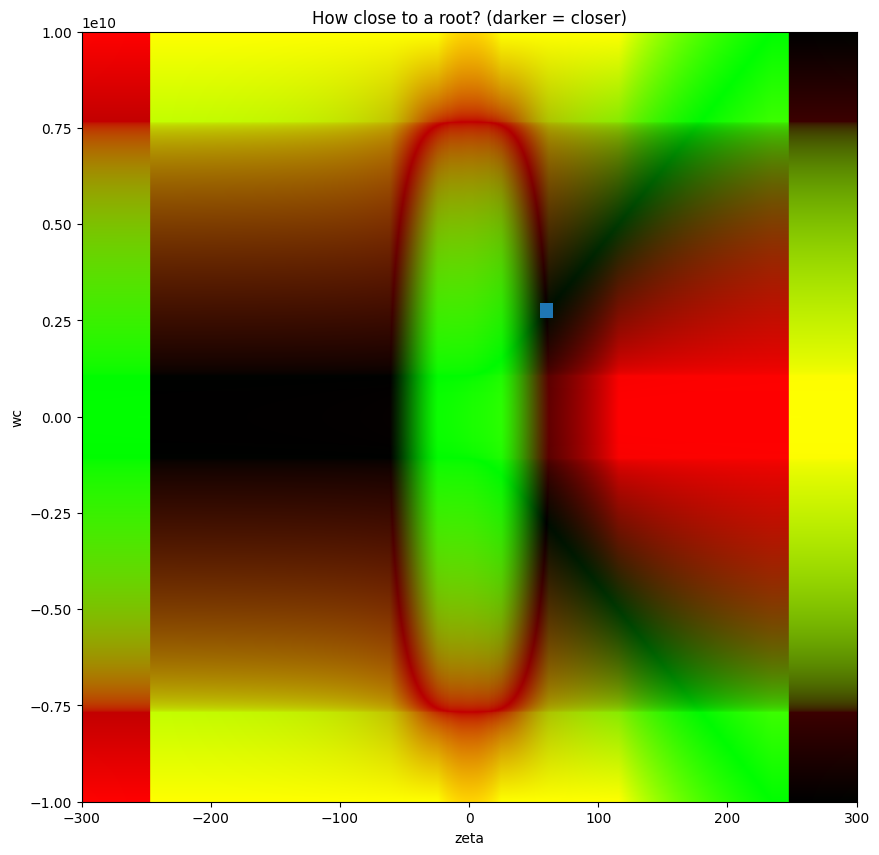

In [ ]:
rd = 9.4e-2
zetas = []
wcs = []
for k in range(-10, 10):
  zeta, wc = Newton(k)
  if abs(zeta.imag) < 1 and abs(wc.imag) < 1:
    zeta, wc = zeta.real, wc.real
    zetas.append(zeta)
    wcs.append(wc)
    print(f"zeta = {zeta:.3e}, wc = {wc:.3e}")

wc = np.linspace(-1e10, 1e10, 1000, dtype=np.complex64)
zeta = np.linspace(-3e2, 3e2, 1000, dtype=np.complex64)
wc, zeta = np.meshgrid(wc, zeta)


# Grab and format data
g0, g1 = np.abs(g(zeta, wc))
g0 -= np.nanmin(g0, axis=-1)[:,None]
g0 /= np.nanmax(g0, axis=-1)[:,None]
g1 -= np.nanmin(g1, axis=-1)[:,None]
g1 /= np.nanmax(g1, axis=-1)[:,None]

print(np.nanmin(g0), np.nanmin(g1))

# Third color that doesn't mean anything.
g2 = np.zeros_like(g1)
plt.figure(figsize=(10,10))
plt.title("How close to a root? (darker = closer)")
plt.imshow(np.array([g0, g1, g2]).T, aspect='auto', extent=[np.amin(zeta),np.amax(zeta),np.amin(wc),np.amax(wc)])
for zeta_sol, wc_sol in zip(zetas, wcs):
  plt.gca().add_patch(plt.Rectangle((zeta_sol-5, wc_sol-2e8),10,4e8))
plt.xlabel("zeta")
plt.ylabel("wc")
plt.show()

Part 1: 
 
Can you measure the resonance frequency via the VNA, whose bandwidth covers 100 kHz to 6 GHz? We cannot measure the resonence frequency via the VNA because they are out of range of the VNA. It is 6.4 GHZ theoretically. 

What would be the expected resonance frequency if you stack the two resonators on top of another, with their central holes as aligned as possible?
The expected resonance frequency would be about half of the original resonence frequency. 

Can you measure the combined stack’s resonance frequency via the VNA? Yes, the combined resonance frequency is now 3.3 GHZ 

Part 2 & 3.


1. Both resonators stacked together.
- With the loop centered we get a peak at 2.9608GHz.
- Moving the loop up/down decreases the amplitude.
- Moving the loop side-to-side changes the frequency.
- Adding a glass slide reduced the readout to noise. It looked like there might be a peak at ~2.68GHz, but that was likely just noise.

Part 4.

1. The intrinsic reading is about 0.25 Gauss, which is due to Earth's magnetic field.

Coil data:

- 95mm radius
- 580 turns


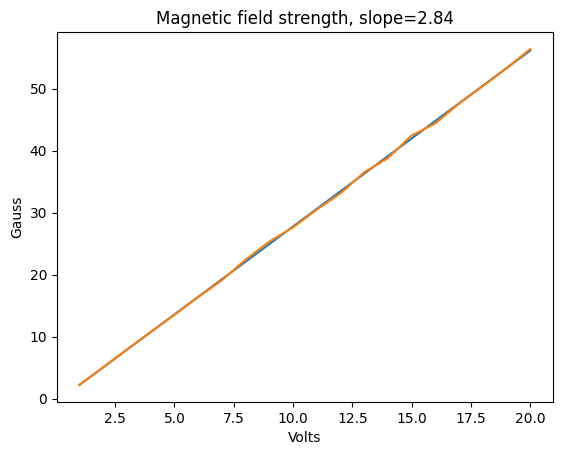

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(1, 20, 20)
y = [2.20, 5.03, 7.91, 10.72, 13.5, 16.36, 19.08, 22.41, 25.33, 27.6, 30.48, 33.09, 36.5, 38.8, 42.45, 44.4, 47.6, 50.4, 53.30, 56.4]

m_volt, b_volt = np.polyfit(x, y, 1)
def volt_to_magnetic_field(v):
  return m_volt * v + b_volt

plt.title(f"Magnetic field strength, slope={m_volt:.2f}")
plt.xlabel("Volts")
plt.ylabel("Gauss")
plt.plot(x, volt_to_magnetic_field(x))
plt.plot(x, y)
plt.show()

# Aim 2
## Part 1

In [ ]:
diamond_density = 3.5e6/12.011 # moles of carbon per m^3
nv_density = 13e-6 * diamond_density # moles of nitrogen per m^3
n = 6.022e23 * nv_density * 3e-3*3e-3*5e-4
print(f"{n:.3e}")
g_eff = 0.01 * n**0.5
print(f"Coupling strength (g effective): {g_eff:.2e}")

1.027e+16
Coupling strength (g effective): 1.01e+06


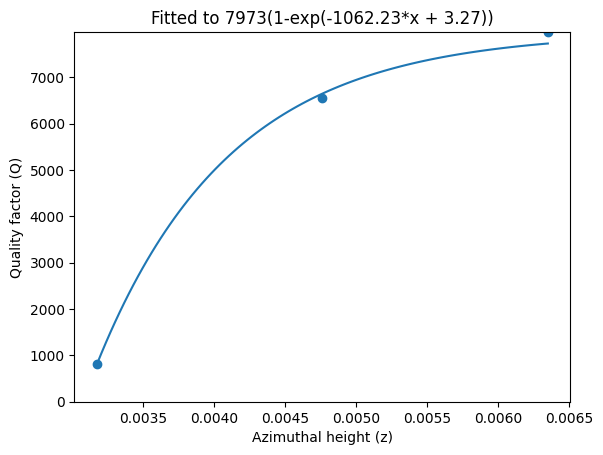

In [ ]:
from scipy.optimize import curve_fit

# Meters above the diamond:
dz = np.array([1/8, 3/16, 1/4]) * 2.54e-2

# Resonance frequency full width at half maximum spans (GHz):
spans = [[2.9537, 2.9573],
         [2.94616, 2.94661],
         [2.94587, 2.94624]]

# Resonance frequency (to 3 sig figs)
wc = 2.95e9

widths = np.array([s[1]-s[0] for s in spans]) * 1e9 # convert to Hz
Q = wc / widths

# Kappa values
k_c0 = widths[-1]

def one_minus_exp(x, A, c):
  return 1 - np.exp(A+c*x)

scale_factor = max(Q)

plt.scatter(dz, Q)
A, c = curve_fit(one_minus_exp, dz, Q / scale_factor)[0]

x = np.linspace(min(dz), max(dz), 100)

def get_Q(x):
  return scale_factor * (1-np.exp(A + c*x))

plt.title(f"Fitted to {scale_factor:.0f}(1-exp({c:.2f}*x + {A:.2f}))")
plt.plot(x, get_Q(x))
plt.ylim(0, scale_factor)
plt.xlabel("Azimuthal height (z)")
plt.ylabel("Quality factor (Q)")

plt.show()

In [ ]:
Q_0 = wc / k_c0
print(f"Intrinsic quality factor is {Q_0:.2e}")

Intrinsic quality factor is 7.97e+03


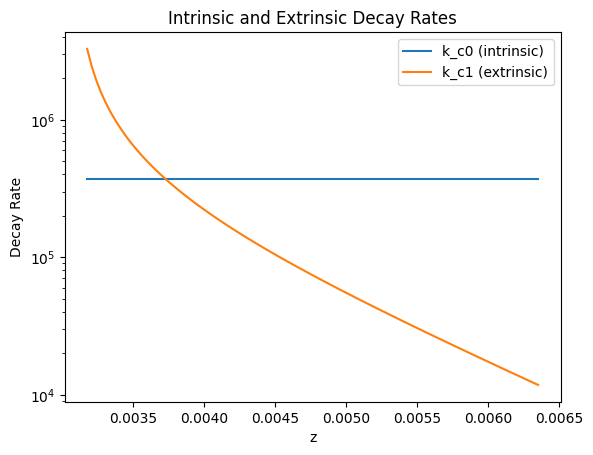

In [ ]:
def get_k_c(z):
  # Returns k_c given the azimuthal height in inches (note this assumes all extrinsic loss is due to the height, not rotation, horizontal translation, etc.)
  return wc / get_Q(z)

def get_k_c1(z):
  return wc / get_Q(z) - wc / Q_0

plt.title(f"Intrinsic and Extrinsic Decay Rates")
plt.plot(x, k_c0*np.ones_like(x), label="k_c0 (intrinsic)")
plt.plot(x, get_k_c1(x), label="k_c1 (extrinsic)")
plt.legend()

plt.xlabel("z")
plt.ylabel("Decay Rate")
plt.yscale('log')

plt.show()

## Part 2


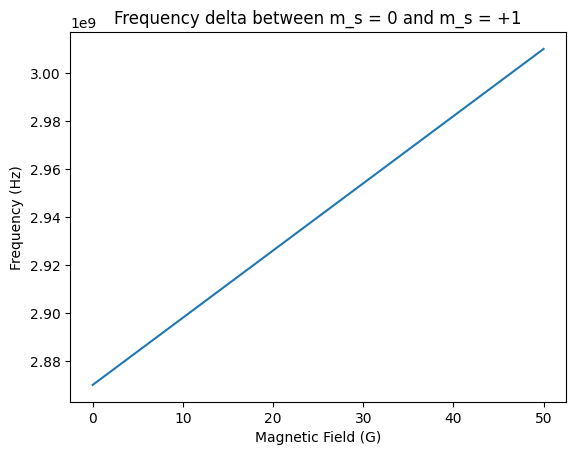

In [ ]:
f = np.linspace(0,50, 51)

def get_w_s(B):
  # Returns splitting frequency (in Hz) given magnetic field strength (in Gauss)
  return 2.87e9 + 2.799e6 * B

y = get_w_s(f)

plt.title("Frequency delta between m_s = 0 and m_s = +1")
plt.xlabel("Magnetic Field (G)")
plt.ylabel("Frequency (Hz)")
plt.plot(f, y)
plt.show()

## Part 3

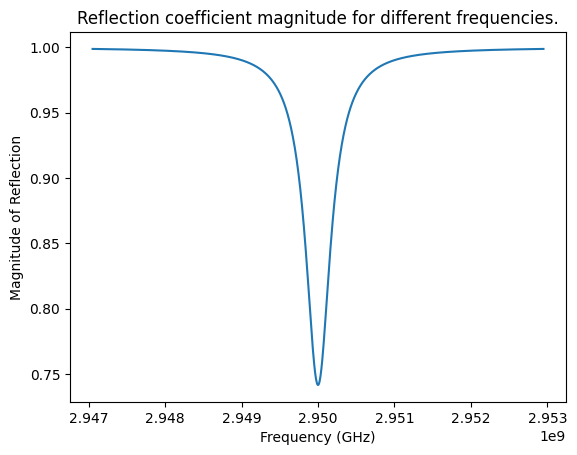

In [ ]:
w_c = 2.95e9 # resonance frequency of cavity
w = np.linspace(w_c*0.999,w_c*1.001, 1000) # probe frequencies
def gamma(w, w_c, k_c, k_c1, g, k_s, w_s, alpha):
  return -1 + k_c1/(k_c/2 + 1j*(w-w_c) + g**2/(k_s/2 + 1j*(w-w_s) + alpha))

z = 5e-3 # assume our probe is 5mm above the cavity
Y = gamma(w, w_c, get_k_c(z), get_k_c1(z), 0, 1, 1, 1) # Ignore last 4 for now


plt.title("Reflection coefficient magnitude for different frequencies.")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude of Reflection")
plt.plot(w, abs(Y))
plt.show()

## Part 4

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider

T2 = 20e-6
k_s = 1/T2
alpha = 0

w_spread = 1e7
w = np.linspace(w_c-w_spread/2, w_c+w_spread/2, 1000) # probe frequencies

B_c=28.5816
B_spread = 0.01
B = np.linspace(B_c+B_spread/2, B_c+B_spread/2, 1000)

w, B = np.meshgrid(w, B)
w_s = get_w_s(B)

def graph(w, w_c, k_c, k_c1, g, k_s, w_s, alpha):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  Y = gamma(w, w_c, k_c, k_c1, g, k_s, w_s, alpha)

  plt.suptitle("Reflection Coefficient")
  ax[0,0].set_title("Real Part")
  ax[0,0].imshow(Y.real, extent=[w_c-w_spread/2,w_c+w_spread/2, B_c-B_spread/2,B_c+B_spread/2], aspect='auto')
  ax[1,0].set_title("Imaginary Part")
  ax[1,0].imshow(Y.imag, extent=[w_c-w_spread/2,w_c+w_spread/2, B_c-B_spread/2,B_c+B_spread/2], aspect='auto')
  ax[0,1].set_title("Magnitude")
  ax[0,1].imshow(abs(Y), extent=[w_c-w_spread/2,w_c+w_spread/2, B_c-B_spread/2,B_c+B_spread/2], aspect='auto')
  ax[1,1].set_title("Phase")
  ax[1,1].imshow(np.angle(Y), extent=[w_c-w_spread/2,w_c+w_spread/2, B_c-B_spread/2,B_c+B_spread/2], aspect='auto')
  fig.supxlabel("Strobe Frequency")
  fig.supylabel("Magnetic Field")
  plt.show()

k_c = get_k_c(z)
k_c1 = get_k_c1(z)
interact(graph, w=fixed(w),
                    w_c=FloatSlider(value=w_c, min=w_c-w_spread/2, max=w_c+w_spread/2, step=0.001*w_spread),
                    k_c=FloatSlider(value=k_c, min=k_c * 0.1, max=k_c * 2, step=k_c/100),
                    k_c1=FloatSlider(value=k_c1, min=k_c1 * 0.1, max=k_c1 * 2, step=k_c1/100),
                    g=fixed(g_eff),
                    k_s=fixed(k_s),
                    w_s=fixed(w_s),
                    alpha=fixed(0),
         readout_format='.5e',
         );

# Good constants:
# w_c = 2.95e9
# k_c = 4.2e5
# k_c1 = 5.5e4

interactive(children=(FloatSlider(value=2950000000.0, description='w_c', max=2955000000.0, min=2945000000.0, s…

# Aim 3
## Prelab


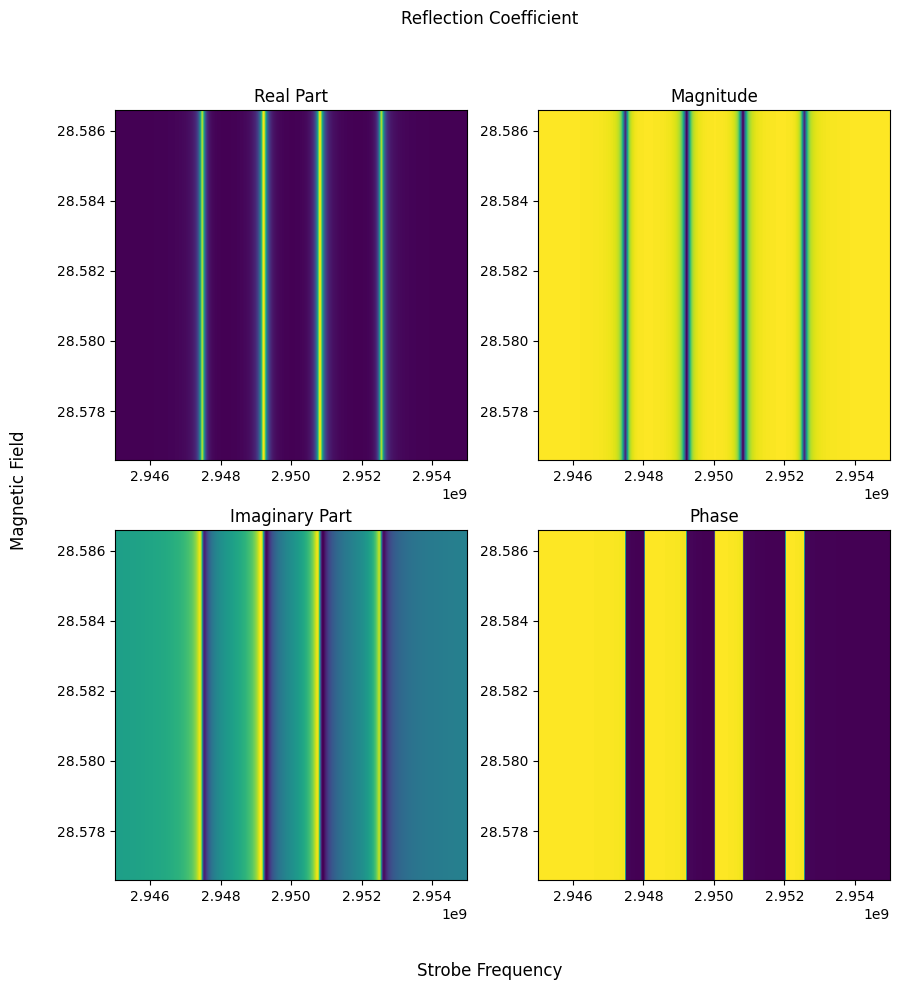

In [ ]:
# NV center electrons are in a triplet state, so there are three splitting frequencies ~2MHz apart.
# It's easier to modify the gamma function than to pass in three splitting frequencies:
def gamma(w, w_c, k_c, k_c1, g, k_s, w_s, alpha):
  splitting_piece = g**2/(k_s/2 + 1j*(w-w_s-2e6) + alpha) + g**2/(k_s/2 + 1j*(w-w_s+2e6) + alpha) + g**2/(k_s/2 + 1j*(w-w_s) + alpha)
  return -1 + k_c1/(k_c/2 + 1j*(w-w_c) + splitting_piece)

graph(w, w_c, k_c, k_c1, g_eff, k_s, w_s, alpha)

# Aim 3

**Question:** If instead of a 561
nm longpass filter, we have a 638
nm optical longpass filter in place. Will you still be able to observe fluorescence? Why or why not?

*Answer:* Since we no longer have the 637 nm light that corresponds to the direct emission from the excited state to the ground state, we will not be able to see as much fluorescence. However, we should still see some from the tail of the fluorescence curve.

**Question:** Are you able to observe any fluorescence? Explain why or why not?

*Answer:* No, because it has many fewer nitrogen vacancies compared to the first diamond, which makes it much more difficult to see any fluorescence.

In [ ]:
%%capture
!pip install qcodes
!pip install qcodes_contrib_drivers
!pip install pyvisa-py

In [ ]:
%%capture
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1kkkXeQyyrg6BMhK2RJBleBGn8OjrYlfB -O libreVNA.py

##Part 1: Interfacing with the power supply

In [ ]:
import pyvisa as visa
rm = visa.ResourceManager('@py')
rm.list_resources()

# import serial.tools.list_ports as ports
# print(list(ports.comports()))

('ASRL/dev/cu.Bluetooth-Incoming-Port::INSTR',)

In [ ]:
import qcodes as qc
import qcodes_contrib_drivers.drivers.RohdeSchwarz.HMP4040 as hmp4040

# Connect to the HMP4040
ps = hmp4040.RohdeSchwarzHMP4040('ps_2', 'ASRL/dev/cu.usbmodemFA131::INSTR')

# Test setting/getting the voltage
ps.ch1.set_voltage.set(0.05)
ps.ch1.set_current.set(0.2)

print(ps.ch1.set_voltage.get())

Connected to: ROHDE&SCHWARZ HMP4040 (serial:103851, firmware:HW50020003/SW2.62) in 0.09s
0.05


#Part 2: Aligning the laser to excite the diamond

If instead of a 561
nm longpass filter, we have a 638
nm optical longpass filter in place. Will you still be able to observe fluorescence? Why or why not?

Since we no longer have the 637 nm light that corresponds to the direct emission from the excited state to the ground state, we will not be able to see as much fluorescence. However, we should still see some from the tail of the fluorescence curve.

##Part 6 and 7: Write an experimental sequence to produce a 2D map of frequency vs magnetic field and Run the experimental sequence and determine if you have achieved strong coupling

In [ ]:
from libreVNA import libreVNA
vna = libreVNA('localhost', 19542)
vna.cmd(":DEV:CONN")
dev = vna.query(":DEV:CONN?")
if dev == "Not connected":
    raise Exception("Failed to connect to aborting")
    exit(-1)
else:
    print("Connected to "+dev)

Connected to 207535AF3750


In [ ]:
ps.ch2.set_voltage.set(26.85)
# ps.ch2.set_current.set(0.001)

In [ ]:
# TODO:
# Set correct frequency center/span.

# 1
vna.cmd(":VNA:FREQuency:CENTer 2956490000")
vna.cmd(":VNA:FREQuency:SPAN 50000")

# 2
vna.cmd(":VNA:ACQ:POINTS 100")

# 3
vna.cmd(":VNA:ACQ:IFBW 1000") #Higher means faster but lower SNR

# 4
vna.cmd(":VNA:ACQ:AVG 2")

Shapes: (9, 100) (9, 100)


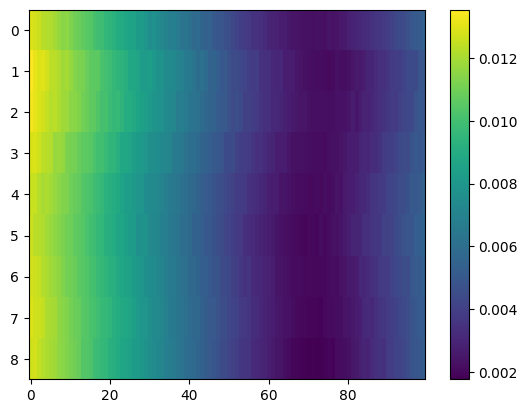

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from time import sleep

voltages = np.arange(26.5,27.3, 0.1) # between 15 and 25 in increments of 0.1
name = "265to273"

freqs = []
var_freqs = []
amps = []
var_amps = []
ps.ch2.set_current.set(10)

ps.ch2.state('ON')
ps.state('ON')

avg_num = 5 # Number of traces to average over for each given voltage
for voltage in voltages:
  ps.ch2.set_voltage.set(voltage)
  temp_freqs = []
  temp_amps = []

  for i in range(avg_num):
    # grab the data of trace S21
    sleep(2) #0.6
    data = vna.query(":VNA:TRACe:DATA? S21")
    S21 = np.array(vna.parse_VNA_trace_data(data), dtype = np.complex64)
    temp_freqs.append(S21[:,0])
    temp_amps.append(abs(S21[:,1]))
  freqs.append(np.mean(temp_freqs, axis = 0))
  var_freqs.append(np.var(temp_freqs, axis = 0))
  amps.append(np.mean(temp_amps, axis=0))
  var_amps.append(np.var(temp_amps, axis=0))
  

ps.ch2.set_voltage.set(26.85)
# ps.ch2.set_current.set(0.001)
# ps.state('OFF')
# ps.ch2.state('OFF')
freqs = np.array(freqs)

volts = np.repeat(voltages, freqs.shape[-1]).reshape(freqs.shape)
mags = volts #volt_to_magnetic_field(volts)
print("Shapes:", mags.shape, freqs.shape)

# Interpolate
# rbf = scipy.interpolate.Rbf(freqs, mags, amps, function='linear')
# xi = np.linspace(np.amin(freqs), np.amax(freqs), 1000)
# yi = np.linspace(np.amin(mags), np.amax(mags), 1000)
# xi, yi = np.meshgrid(xi, yi)
# zi = rbf(xi, yi)

plt.imshow(amps, aspect='auto')
# plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
#            extent=[x.min(), x.max(), y.min(), y.max()])
# plt.scatter(x, y, c=z)
plt.colorbar()
plt.show()
plt.savefig("plot" + name)

In [ ]:
 with open("amps"+name+".txt", "wb") as f:
  np.save(f, amps)

with open("freqs"+name+".txt", "wb") as f:
  np.save(f, freqs)

# with open("mags15to26-5.txt", "wb") as f:
#   np.save(f, mags)

# with open("var_amps15to26-5.txt", "wb") as f:
#   np.save(f, var_amps)

# with open("var_freqs15to26-4.txt", "wb") as f:
#   np.save(f, var_freqs)

# with open("settings15to26-4.txt", "w") as f:
#   f.write("""# TODO:
# # Set correct frequency center/span.

# # 1
# vna.cmd(":VNA:FREQuency:CENTer 2955810000")
# vna.cmd(":VNA:FREQuency:SPAN 45000")

# # 2
# vna.cmd(":VNA:ACQ:POINTS 100")

# # 3
# vna.cmd(":VNA:ACQ:IFBW 1000") #Higher means faster but lower SNR

# # 4
# vna.cmd(":VNA:ACQ:AVG 1"); also -30db level. #6 swept from 22 to 26 V, #7 went from 22 to 28, and #8 is from 22 to 30, and #9 is 23.5 to 30""")

#Part 8: Estimate the sensitivity
 

In [ ]:
phase_noise = -103 #dBc/Hz
meas_dBm = -30 #dBm

def dBm_to_V(x):
  return (50/1000)**0.5 * 10 ** (x/20)

print(dBm_to_V(-133))


5.0059326485045294e-08


Sensitivity is Tesla/sqrt(hz) 

1.
Conversion of phase noise to dBm/Hz: This would just be -30 dBm + -103 dBm/hz = -133 dBm/hz (read from this article https://www.edaboard.com/threads/how-to-convert-dbc-to-dbm-thanks.142115/) 


https://electronics.stackexchange.com/questions/601587/converting-db-vs-frequency-to-v-sqrthz-frequency unsure if there is a difference between v and v-rms 
Now conversion to V_rms/sqrt(hz) using online calculator https://3roam.com/dbm-hz-to-nv-sqrt-hz-calculator/ with the assumption of 50 ohms. 

5.0059326485045294e-8 volts/sqrt(hz) 


2. https://calculator.academy/dbm-to-rms-voltage-calculator/ 

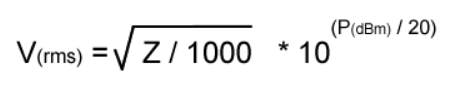

/Users/qpgroup/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/qpgroup/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/qpgroup/opt/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


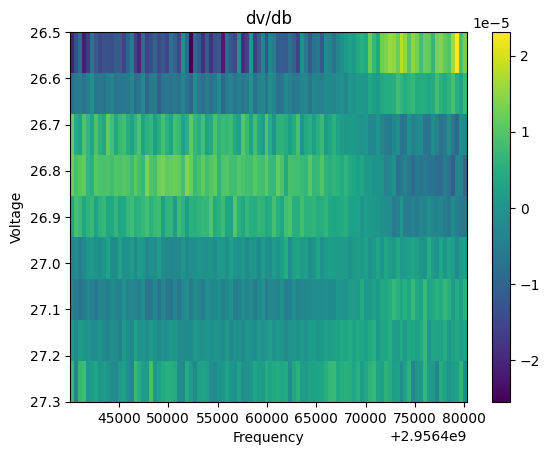

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from time import sleep
x = np.linspace(1, 20, 20)
y = [2.20, 5.03, 7.91, 10.72, 13.5, 16.36, 19.08, 22.41, 25.33, 27.6, 30.48, 33.09, 36.5, 38.8, 42.45, 44.4, 47.6, 50.4, 53.30, 56.4]

m_volt, b_volt = np.polyfit(x, y, 1)
def volt_to_magnetic_field(v):
  return m_volt * v + b_volt

volts = np.arange(27.3,26.5,-0.1) #is reversed for some reason
# mags = volt_to_magnetic_field(volts)
# name = "225to245"
amp = (np.load("amps"+name+".txt"))[:][:]
freq = (np.load("freqs"+name+".txt"))

plt.xlabel("Frequency")
plt.ylabel("Voltage")
plt.title("dv/db")
# print(amp.shape)
db = (volts[-1] - volts[0])  #0.184567744 
# print(freq.shape)
# print(freq[-1][0])
plt.imshow(np.gradient(dBm_to_V(amp))[0]/ db, aspect='auto', extent= [freq[0][0], freq[0][80], volts[0], volts[-1]]) #,vmin = -2e-6, vmax=2e-6 
plt.colorbar()
plt.show()
plt.savefig("plot"+name+"dv")



\With a maximum dv/db(read from colorplot) of ~1*10^-4 volts/guass
Dividing 5.0059326485045294e-8 volts/sqrt(hz) by the max dv/db
and getting 34,000 pt/sqrt(hz)


#Working With Phase

In [ ]:
#Look at phase
# TODO:
# Set correct frequency center/span.

# 1
vna.cmd(":VNA:FREQuency:CENTer 2956840000") 
vna.cmd(":VNA:FREQuency:SPAN 40000")

vna.cmd(":VNA:ACQ:POINTS 1") # Only acquire one point at a time
vna.cmd(":VNA:ACQ:AVG 1") # And don't do averaging (we can do that ourselves)
vna.cmd(":VNA:ACQ:IFBW 100000") #Higher means faster but lower SNR



In [ ]:
import time
angles = []

time_per_loop = 0.0005
loops = 200000
total_start = time.perf_counter()
for i in range(loops):
    data = vna.query(":VNA:TRACe:AT? S21 2956838000") #Best at 295636
    data = data.replace(",-","-")
    data = data.replace(",","+")
    # print(data)
    angles.append(np.angle(complex(data+'j')))
    while time.perf_counter() < total_start + time_per_loop*(i+1):
        pass
print(time.perf_counter()-total_start)
#print(len(angles)/10)


100.00651028100401


100.00713926498429
10000.0


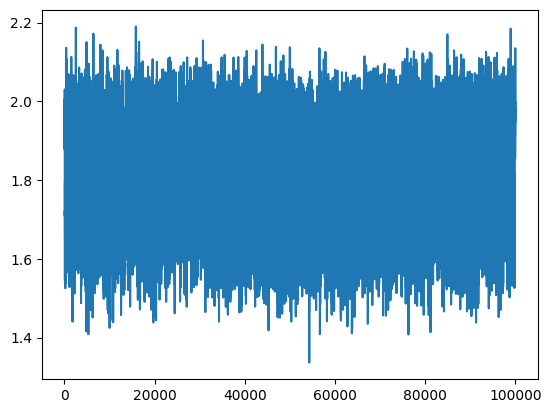

In [ ]:
# import time
# angles = []

# time_per_loop = 0.001
# loops = 100000
# total_start = time.perf_counter()
# for i in range(loops):
#     data = vna.query(":VNA:TRACe:DATA? S21")
#     S21 = np.array(vna.parse_VNA_trace_data(data), dtype = np.complex64)
#     angles.append(np.angle(S21[:,1]))
#     while time.perf_counter() < total_start + time_per_loop*(i+1):
#         pass
# print(time.perf_counter()-total_start)
# #print(len(angles)/10)



2.416338460614753


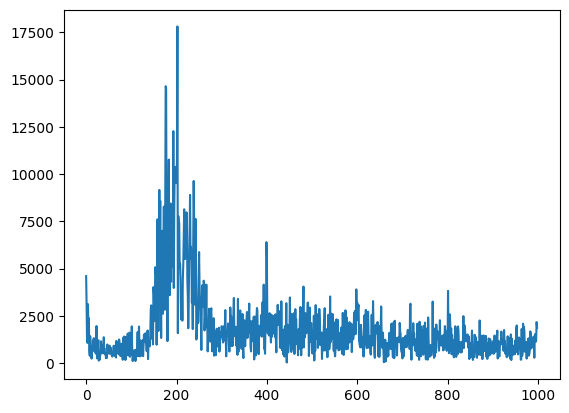

202


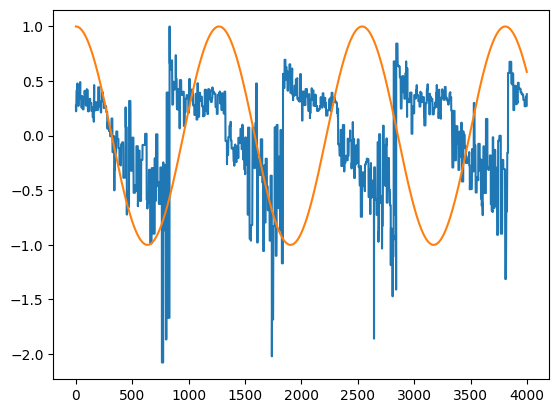

In [ ]:
from scipy.signal import hilbert
print(angles[1])
angles = np.array(angles) % (2*np.pi)
angles[angles > 4] = angles[angles > 4] - 2*np.pi

analytic = hilbert(angles)
envelope = np.abs(analytic)

k = np.argmax(abs(np.fft.fft(envelope)[1:]))
plt.plot(abs(np.fft.fft(envelope)[1:1000]))
plt.show()
print(k)
t1 = k * time_per_loop

x = np.arange(4000)
y = angles[x]
y -= np.mean(y)
y /= np.amax(y)
plt.plot(x, y)
plt.plot(x, np.cos(x / k))
plt.show()

# plt.plot(np.fft.fft(angles)[100:600])

[   248   2404   4363   6224   8416  10229  12958  16061  17932  20920
  22793  24772  27133  29546  32285  34677  37080  39414  41602  43949
  46412  48377  50468  52377  54422  56229  58339  60370  62294  64122
  66419  68451  70278  72304  74413  76454  78421  80345  82396  84424
  86437  88417  90271  92445  94421  96433  98404 100399 102358 104465
 106324 108425 110461 112386 114367 116426 118424 120354 122398 124287
 126494 128505 132065 134073 136133 138356 140672 142623 144630 147023
 149341 151625 154016 156383 158747 161536 164135 166106 168394 170409
 172398 174449 176443 178274 180366 182428 184423 186393 188421 190301
 192332 194448 196278 198448]
[2156, 1959, 1861, 2192, 1813, 2729, 3103, 1871, 2988, 1873, 1979, 2361, 2413, 2739, 2392, 2403, 2334, 2188, 2347, 2463, 1965, 2091, 1909, 2045, 1807, 2110, 2031, 1924, 1828, 2297, 2032, 1827, 2026, 2109, 2041, 1967, 1924, 2051, 2028, 2013, 1980, 1854, 2174, 1976, 2012, 1971, 1995, 1959, 2107, 1859, 2101, 2036, 1925, 1981, 2059, 

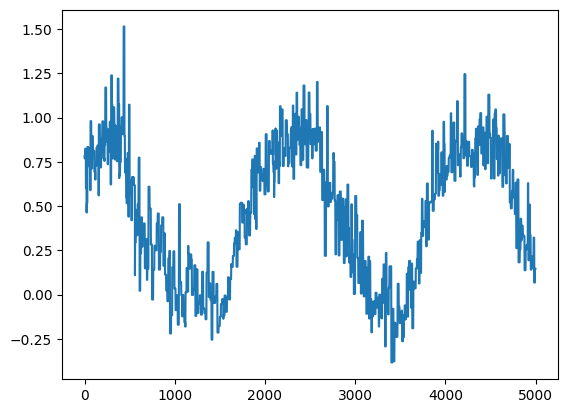

In [ ]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
# def sine_func(x, amplitude, frequency, phase, c):
#     return amplitude * np.sin(2 * np.pi * frequency * x + phase) + c

# # Fit the data to the function
# popt, pcov = curve_fit(sine_func, np.arange(len(angles)), np.array(angles)[:, 0], p0 = [0.2,1/360, 0, 0.9])

# print(popt)
# a,f,p,c = popt
# plt.plot(a*np.sin(2*np.pi*np.linspace(0, 3000, 3000)*f+p)+c)

ang = np.array(angles)
mva = np.convolve(ang, np.ones(200)/200, mode='valid')
# plt.plot(np.fft.fft(mva - mva.mean())[200:250])

# ang = np.load("Great T1 Data.npy")
plt.plot(ang[:5000])

# plt.plot(ang[:3000])

# Find the indices of all the local maxima
peaks, _ = find_peaks(mva, distance = 1800)
print(peaks)
peaks_sub = []
for i in range(len(peaks)-1):
  peaks_sub.append(peaks[i+1]-peaks[i])
print(peaks_sub)
print(np.mean(peaks_sub), np.std(peaks_sub))

(50, 4000)


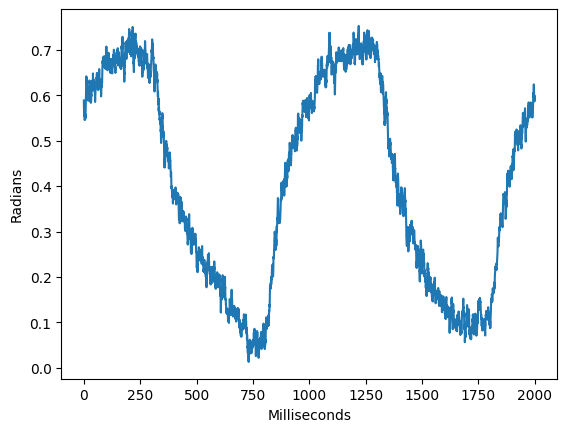

In [ ]:
n = 4000
k = n * (len(ang) // n)


reshaped_ang = ang.reshape(-1,n)
print(reshaped_ang.shape)
avg_ang = np.mean(reshaped_ang, axis = 0)
plt.plot(np.arange(0,n/2,0.5),avg_ang)
plt.ylabel("Radians")
plt.xlabel("Milliseconds")

# np.save("Great T1 Data #6", avg_ang)


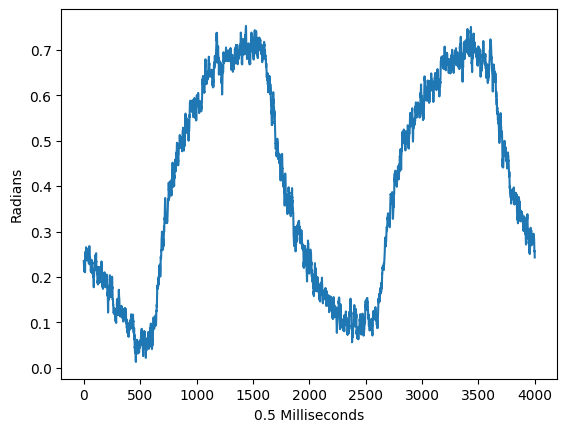

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

avg_ang6 = np.load("Great T1 Data #6.npy")
avg_ang6 = np.roll(avg_ang6,3000)
plt.plot(avg_ang6)
plt.ylabel("Radians")
plt.xlabel("0.5 Milliseconds")

n = len(avg_ang6)

T1 Times:  117.55540721616867 139.4465630190375 116.45248649705492
T1 STD:  -1.128644526528013 -1.6429102172853909 -1.3554763337911475
R2:  0.9860245139417735
R2:  0.9824786994578415
R2:  0.9794153256938887


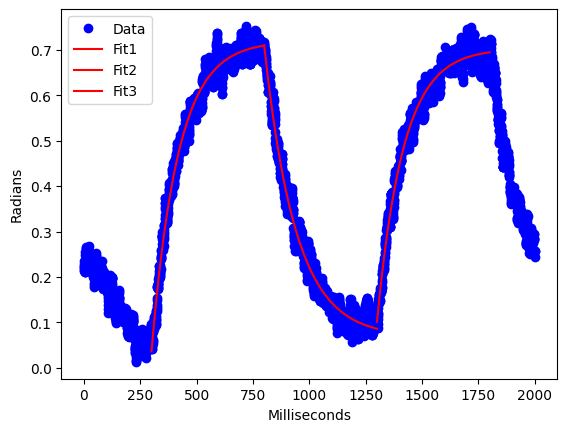

In [ ]:
def exponential(x, a, b, c):
    return a * np.exp(1/b * x) + c



x = np.arange(0,n/8,0.5)
start = 600 # Was 115
interval = int(n/4)
y1 = avg_ang6[start:start+interval]
y2 = avg_ang6[start+interval:start+2*interval]
y3 = avg_ang6[start+2*interval:start+3*interval]

popt1, pcov1 = curve_fit(exponential, x, y1, p0 = [0.85, -100, 0])
popt2, pcov2 = curve_fit(exponential, x, y2, p0 = [-2.5, -100, 2])
popt3, pcov3 = curve_fit(exponential, x, y3, p0 = [0.15, -100, 0.85])
print("T1 Times: ", -popt1[1], -popt2[1], -popt3[1])
perr1 = np.sqrt(np.diag(pcov1))
perr2 = np.sqrt(np.diag(pcov2))
perr3 = np.sqrt(np.diag(pcov3))


print("T1 STD: ", -perr1[1], -perr2[1], -perr3[1])


# Plot the fitted function along with the data
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y1_pred = exponential(x, *popt1)
print("R2: ", r2_score(y1, y1_pred))
y2_pred = exponential(x, *popt2)
print("R2: ", r2_score(y2, y2_pred))
y3_pred = exponential(x, *popt3)
print("R2: ", r2_score(y3, y3_pred))


plt.plot(np.arange(0,n/2,0.5), avg_ang6, 'bo', label='Data')
plt.plot(x+start/2, exponential(x, *popt1), 'r-', label='Fit1')
plt.plot(x+n/8+start/2, exponential(x, *popt2), 'r-', label='Fit2')
plt.plot(x+n/4+start/2, exponential(x, *popt3), 'r-', label='Fit3')
plt.legend()
plt.ylabel("Radians")
plt.xlabel("Milliseconds")
plt.show()
# plt.savefig("Great T1 Data Plot #2")


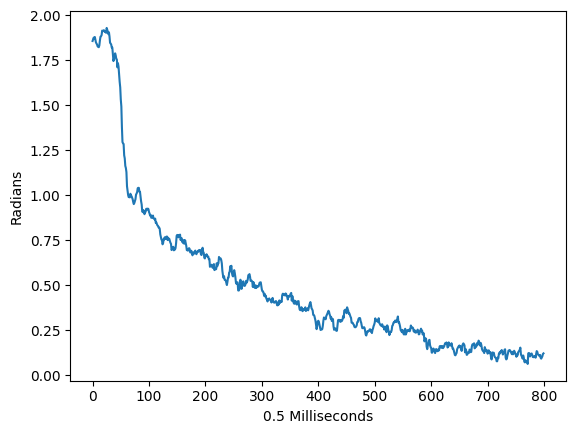

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

avg_ang5 = np.load("Great T1 Data #5.npy")
avg_ang5 = np.roll(avg_ang5, 1200)
# plt.plot(avg_ang5)
plt.ylabel("Radians")
plt.xlabel("0.5 Milliseconds")

n = len(avg_ang5)
plt.plot(avg_ang5[2500:3300])
# plt.plot(np.gradient(avg_ang5))

In [1]:
def exponential(x, a, b, c):
    return a * np.exp(1/b * x) + c

def exp_sum(x, a, b, c, d, e):
    return a * np.exp(1/b * x) + c * np.exp(1/d * x) + e

def exp_drop(x, a, b, c, e):
    return a * np.exp(1/b * x) + c * np.exp(-1/140 * x) + e

def exp_rise(x, a, b, c, e):
    return a * np.exp(1/b * x) + c * np.exp(-1/120 * x) + e

new_ang = np.roll(avg_ang5,-500)

interval = 950
x = np.arange(0,interval/2,0.5)
interval2 = 600
x2 = np.arange(0,interval2/2,0.5)
start = 1100
start2 = 1035 + 1000

y1 = new_ang[start:start+interval]
y2 = new_ang[start2:start2 + interval2]
# y3 = avg_ang[start+2*interval:start+3*interval]

# Exponential Fits

# popt1, pcov = curve_fit(exponential, x, y1, p0 = [2.5, -0.01, -0.5])
# popt2, pcov = curve_fit(exponential, x, y2, p0 = [-2.5, -0.01, 2])
# popt3, pcov = curve_fit(exponential, x, y3, p0 = [0.15, -0.01, 0.85])

# Sum of Exponential Fits

popt1, pcov1 = curve_fit(exp_rise, x, y1, p0 = [-0.6, -5, -1, 2], bounds = ([-2.1,-13,-2.1,1.6],[-0.4,0,-0.4,2.2]))
popt2, pcov2 = curve_fit(exp_drop, x2, y2, p0 = [1, -5, 1, 0])

print("T1 Times: ", -popt1[1], -popt2[1])
perr1 = np.sqrt(np.diag(pcov1))
perr2 = np.sqrt(np.diag(pcov2))


print("T1 STD: ", -perr1[1], -perr2[1])

# Plot the fitted function along with the data
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y1_pred = exp_drop(x, *popt1)
print("R2: ", r2_score(y1, y1_pred))
y2_pred = exp_rise(x2, *popt2)
print("R2: ", r2_score(y2, y2_pred))
# y3_pred = exponential(x, *popt3)
# print("R2: ", r2_score(y3, y3_pred))

print(popt1)
print(popt2)

plt.plot(np.arange(0,n/2,0.5), new_ang, 'bo', label='Data')
plt.plot(x+start/2, exp_rise(x, *popt1), 'r-', label='Fit1')
plt.plot(x2+start2/2, exp_drop(x2, *popt2), 'r-', label='Fit2')
# plt.plot(x+n/4+start/2, exponential(x, *popt3), 'r-', label='Fit3')
plt.legend()
plt.ylabel("Radians")
plt.xlabel("Milliseconds")
plt.show()
# plt.savefig("Great T1 Data Plot #2")


NameError: ignored

In [ ]:

zoom = avg_ang5[2500:3000]
# plt.plot(zoom)



end = 230
x = np.arange(0,end,0.5)
y = zoom[500-2*end:]

popt, pcov = curve_fit(exp_drop, x, y, p0 = [1, -5, 1, 0])
perr = np.sqrt(np.diag(pcov))
print("T1 Times: ", -popt[1])
print("T1 STD: ", perr[1])

y_pred = exp_drop(x, *popt)
print("R2: ", r2_score(y, y_pred))

plt.plot(x, y, 'bo', label='Data')
plt.plot(x, exp_drop(x, *popt), 'r-', label='Fit1')
plt.legend()
plt.ylabel("Radians")
plt.xlabel("Milliseconds")
plt.show()


NameError: ignored

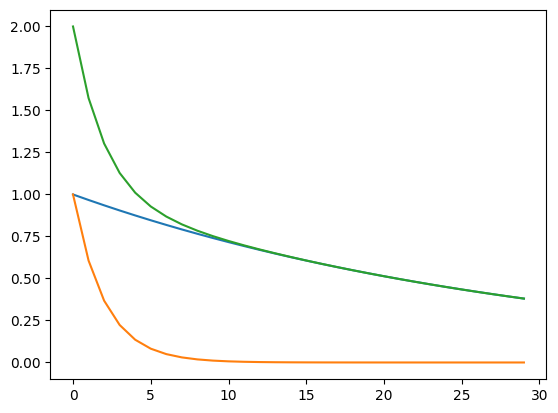

In [ ]:
import scipy.signal as sig

# result, remainder = sig.deconvolve(avg_ang5, avg_ang6)
# print(result, remainder)
x1 = np.arange(0,30,1)
a = exponential(x1, 1, -30, 0)
b = exponential(x1, 1, -2, 0)
c = a+b

plt.plot(a)
plt.plot(b)
plt.plot(c)

# test1 = np.roll(avg_ang5, 0)
# test2 = np.roll(avg_ang5, -90)
# test3 = np.roll(avg_ang5, -100)
# test4 = np.roll(avg_ang5, -150)
# test5 = np.roll(avg_ang5, -200)

# other = np.roll(test2-avg_ang6,-1000)

# plt.plot(other)


#Oscilloscope Connection


In [ ]:
!pip install keyoscacquire


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import keyoscacquire as koa
import matplotlib.pyplot as plt

def averaged_trace(scope, measurement_number, averages=8):
    # Set the number of averages and get a trace
    time, voltages, _ = scope.set_options_get_trace(acq_type=f"AVER{averages}")
    # Save the trace data as a csv and a png plot, without showing the plot
    # (the averaging mode and the number of averages is also automatically
    # saved inside the file, together with a timestamp and more)
    scope.save_trace(fname=f"measurement{measurement_number}_AVER{averages}",
                     showplot=False)
    return time, voltages


def different_averaging(visa_address, measurement_number):
    # Connect to the scope
    with koa.Oscilloscope(address=visa_address) as scope:
        # Set the channels to view on the scope
        scope.active_channels = [1, 3]
        # Prepare a two panel plot
        fig, ax = plt.subplots(nrows=2, sharex=True)
        # Obtain traces for different numbers of averages
        for averages in [2, 4, 8, 16, 32]:
            time, voltages = averaged_trace(scope, measurement_number, averages=averages)
            # Plot channel 1 to ax[0] and ch 3 to ax[1]
            for a, ch in zip(ax, voltages.T):
                a.plot(time, ch, label=f"{averages}", alpha=0.5)
        # Add legends to and labels to both plots
        for a, ch_num in zip(ax, scope.active_channels):
            a.set_xlabel("Time [s]")
            a.set_ylabel(f"Channel {ch_num} [V]")
            a.legend()
    plt.show()


different_averaging(visa_address="USB0::2391::6050::MY50510375::INSTR",
                    measurement_number=1)

AttributeError: ignored